# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

39764


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
import matplotlib

plt.style.use('default')

matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Refgen for gene dist matrix

Example of [refgen](../0_locus_annotation/resources/refgen_df_for_jie.csv)

In [9]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [10]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [11]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load pre-summarized transcription density medians

Data can be generated from notebook

[7_summarize_ab_trans_density_all_loci_subclass](7_summarize_ab_trans_density_all_loci_subclass.ipynb)

In [12]:
# the calculated AB desnity ratio for single-cell
#compartment_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
AB_summary_fname = os.path.join(output_analysis_folder , r'Median_Summary_trans_AB_ratio_notNorm_r0.5_bysubclass_th_zero.csv')

AB_ratio_summary = pd.read_csv(AB_summary_fname, index_col=0).transpose()
AB_ratio_summary

,Oligo,OPC,Micro,Astro,Endo,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L6 CT,L5/6 NP,L6b,Vip,Pvalb,Lamp5,Sst,Sncg
chr1_3742742_3759944,-0.422395,-0.336774,-0.278088,-0.489602,0.087817,-0.474198,-0.424039,-0.397661,-0.433375,-0.406431,-0.441964,-0.261607,-0.355470,-0.242751,-0.365409,-0.271475,-0.348622,-0.396724
chr1_6245958_6258969,-0.123587,-0.183419,-0.065169,-0.251864,0.346057,-0.384096,-0.395186,-0.374351,-0.342256,-0.363363,-0.392261,-0.175218,-0.197491,-0.301612,-0.214871,-0.229265,-0.127568,-0.257080
chr1_8740008_8759916,-0.384446,-0.052034,-0.286666,-0.411412,0.014480,-0.355418,-0.283315,-0.337409,-0.340426,-0.234319,-0.418353,-0.480288,-0.499484,0.005046,-0.199206,-0.062207,-0.122095,-0.540594
chr1_9627926_9637875,-0.229349,-0.036024,0.030728,-0.166186,0.244415,-0.300878,-0.238133,-0.336847,-0.161302,-0.240122,-0.237506,-0.296984,-0.294759,-0.280499,-0.201809,-0.023237,-0.200314,-0.325647
chr1_9799472_9811359,-0.079250,-0.062537,0.222733,-0.080703,0.478925,-0.249645,-0.248266,-0.203845,-0.208270,-0.187555,-0.207870,-0.272937,-0.285443,-0.315864,-0.393889,-0.104418,-0.167614,-0.507851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_166247682_166259932,0.227213,0.121523,0.065605,0.364292,0.309217,-0.056365,-0.012575,-0.208386,-0.175914,-0.006859,-0.067705,0.058149,0.053279,-0.145523,-0.236549,-0.223829,-0.154113,-0.555910
chrX_167157164_167167452,0.102458,-0.135584,0.430749,0.054695,0.556941,-0.123888,-0.062526,-0.143780,-0.118719,-0.155330,-0.107538,0.072693,-0.160688,0.084008,-0.043039,-0.279229,-0.138286,-0.334614
chrX_168746045_168757590,-0.134512,-0.316071,-0.007819,-0.168453,0.254124,-0.243110,-0.215402,-0.186746,-0.175388,-0.235237,-0.294560,0.249351,-0.281637,-0.231542,-0.059648,-0.344906,-0.176298,-0.444930
chrX_169963295_170005197,-0.079956,0.124813,0.064583,0.029156,0.540016,-0.190289,-0.220554,-0.244034,-0.318961,-0.223761,-0.311680,-0.025918,-0.114135,-0.251041,-0.095843,-0.342024,-0.191063,-0.196725


## calculate regression factor between celltypes

In [13]:
### get Abratio normalization dict
from scipy import stats
from sklearn.linear_model import LinearRegression

# use common ref to regress which has more number of data
regress_each = False

ab_regression_coef_dict = {}

#ref_cls = 'Gluta'
# do regression for each class as ref_cls because the downstream marker gene analysis will be similar



if not regress_each:
    ref_cls = 'L2/3 IT'
    for _cls in AB_ratio_summary.columns:
        xs = np.array(AB_ratio_summary[ref_cls].tolist())
        ys = np.array(AB_ratio_summary[_cls].tolist())
        # correlation
        xs_good = xs[(~np.isnan(xs)&(~np.isnan(ys)))]
        ys_good = ys[(~np.isnan(xs)&(~np.isnan(ys)))]
        X=xs_good.reshape(-1, 1)
        y=ys_good.reshape(-1, 1)

        if len(X) > 0:
            reg = LinearRegression(fit_intercept=True).fit(X, y)
            #reg = LinearRegression(fit_intercept=False).fit(X, y)
            #y_pred = reg.predict(X)
            ab_regression_coef_dict[_cls] = (reg.coef_[0], reg.intercept_)
        else:
            ab_regression_coef_dict[_cls] = (np.nan, np.nan)

    
else:
    for ref_cls in AB_ratio_summary.columns:
        ab_regression_coef_dict[ref_cls] = {}

        for _cls in AB_ratio_summary.columns:
            xs = np.array(AB_ratio_summary[ref_cls].tolist())
            ys = np.array(AB_ratio_summary[_cls].tolist())
            # correlation
            xs_good = xs[(~np.isnan(xs)&(~np.isnan(ys)))]
            ys_good = ys[(~np.isnan(xs)&(~np.isnan(ys)))]
            X=xs_good.reshape(-1, 1)
            y=ys_good.reshape(-1, 1)

            if len(X) > 0:
                reg = LinearRegression(fit_intercept=True).fit(X, y)
                #reg = LinearRegression(fit_intercept=False).fit(X, y)

                #y_pred = reg.predict(X)
                ab_regression_coef_dict[ref_cls][_cls] = (reg.coef_[0], reg.intercept_)
            else:
                ab_regression_coef_dict[ref_cls][_cls] = (np.nan, np.nan)

ab_regression_coef_dict

{'Oligo': (array([0.84386026]), array([0.12749563])),
 'OPC': (array([0.7714856]), array([0.10379519])),
 'Micro': (array([0.71329066]), array([0.17957617])),
 'Astro': (array([0.77852525]), array([0.14804139])),
 'Endo': (array([0.47341445]), array([0.40170306])),
 'L2/3 IT': (array([1.]), array([-1.04083409e-17])),
 'L4/5 IT': (array([0.85274508]), array([-0.00076965])),
 'L5 IT': (array([0.75140804]), array([-0.0239076])),
 'L6 IT': (array([0.8351338]), array([-0.01002363])),
 'L5 ET': (array([0.60569472]), array([-0.02951882])),
 'L6 CT': (array([0.89414072]), array([-0.00783821])),
 'L5/6 NP': (array([0.56682118]), array([-0.03419425])),
 'L6b': (array([0.5758625]), array([-0.02862909])),
 'Vip': (array([0.43362486]), array([-0.05669304])),
 'Pvalb': (array([0.58494893]), array([-0.06387273])),
 'Lamp5': (array([0.49342148]), array([-0.04168428])),
 'Sst': (array([0.48583053]), array([-0.05148539])),
 'Sncg': (array([0.51772875]), array([-0.08075471]))}

# 4. Process all cellgroups for the markers

## Define shared parameters

In [14]:
# the cell groups to be analyzed
sorted_group_order = ['L2/3 IT', 'L4/5 IT', 'L5 IT',
       'L6 IT', 'L5 ET', 'L6 CT', 'L5/6 NP', 'L6b', 'Vip', 'Pvalb', 'Lamp5',
       'Sst', 'Sncg']


## Load raw AB ratio if needs to re-calculate the median

Data can be generated from the notebook

[5_compute_ab_trans_density_singlecelll_subclass](5_compute_ab_trans_density_singlecelll_subclass.ipynb)

In [15]:
# the calculated AB desnity ratio for single-cell
#compartment_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
AB_ratio_fname = os.path.join(output_analysis_folder , r'trans_AB_ratio_notNorm_r0.5_bysubclass_th_zero.pkl')

import pickle
AB_ratio_by_group = pickle.load(open(AB_ratio_fname, 'rb'))

## Loop to process each cell group

### Load marker gene selections

Data can be generated from the notebook

[8_marker_gene_selection_neurons](8_marker_gene_selection_neurons.ipynb)

In [16]:
# re-import functions
import loci_1d_features as lf
import gene_selection as gs
import gene_to_loci as gl

re_calculate_AB = False

In [18]:
# compile result as (marker loci of group) by (median of sc for group)
compiled_df = pd.DataFrame(columns = sorted_group_order)

for _marker_group in sorted_group_order[:]:
    
    print(f'Load existing marker gene dataframe for {_marker_group}')

    _marker_savename = _marker_group.replace("/","_")
    _groupby_savename = 'class' #typo in filename from the upstream analysis
    marker_genes_fname = os.path.join(output_analysis_folder,
                                      'marker_neuron',
                                      f'{_groupby_savename}_{_marker_savename}_vs_rest.csv')
    im_loci_df = pd.read_csv(marker_genes_fname, index_col=0)

    ##############################################################################
    # 2. load AB ratio for relevant loci
    for _dir in ['upregulated','downregulated']:

        sel_im_loci_df = im_loci_df[im_loci_df['Expression_change']==_dir]
        # initate result df here so marker of each direction can be independently saved
        _marker_group_df = pd.DataFrame(columns = sorted_group_order)
        # get chr and chr_order
        sel_loci_key_list = lf.sorted_loci_keys_for_loci_dataframe(sel_im_loci_df)
        #original_inds = lf.find_chr_loci_iloc_from_loci_keys (codebook_df, sel_loci_key_list)

        # use chr and chr_order to retrieve AB ratio from single cell
        for loci_key in sel_loci_key_list:
            # append result for each loci from single cell
            # function to get the AB ratio for all cell group and append together
            if re_calculate_AB:
                _loci_group_df = loci_1d_features.sc_compartment_ratio_by_loci_key (AB_ratio_by_group, 
                                                                               sorted_group_order, 
                                                                                loci_key, 
                                                                                report_type = 'median',
                                                                                average_ratios_in_cell=True, 
                                                                                spot_num_th=500)
            else:
                _loci_name = codebook_df[(codebook_df['chr']==str(loci_key[0])) & (codebook_df['chr_order']==loci_key[1])].index[0]
                _loci_group_df = pd.DataFrame(AB_ratio_summary.loc[_loci_name]).transpose()
                _loci_group_df = _loci_group_df.reset_index(drop=True)

                
            if not regress_each:
                for _group in sorted_group_order:
                    m, b = ab_regression_coef_dict[_group][0],ab_regression_coef_dict[_group][1]
                    _loci_group_df.loc[0, _group] = (_loci_group_df.loc[0, _group]-b)/m 


            # concat loci
            _marker_group_df=pd.concat([_marker_group_df,_loci_group_df])


        # add loci, expression, group, gene info, etc
        _marker_group_df['loci_name'] = sel_im_loci_df.index.tolist()
        _marker_group_df['Marker_gene'] = sel_im_loci_df['Marker_gene'].tolist()
        _marker_group_df['Marker_group']=_marker_group
        _marker_group_df['Expression_change']=_dir

        # regression to normalize ABratio using the marker group as ref_cls
        if regress_each:
            for _group in sorted_group_order:
                m, b = ab_regression_coef_dict[_marker_group][_group][0],ab_regression_coef_dict[_marker_group][_group][1]
                _marker_group_df.loc[:, _group] = (_marker_group_df.loc[:, _group]-b)/m 
            # concat loci
            _marker_group_df=pd.concat([_marker_group_df,_loci_group_df])

        # concat for the marker cell group                  
        compiled_df=pd.concat([compiled_df,_marker_group_df])

    print('================================================================================')

# set loci_name as index 
compiled_df=compiled_df.set_index('loci_name')    

Load existing marker gene dataframe for L2/3 IT
Load existing marker gene dataframe for L4/5 IT
Load existing marker gene dataframe for L5 IT
Load existing marker gene dataframe for L6 IT
Load existing marker gene dataframe for L5 ET
Load existing marker gene dataframe for L6 CT
Load existing marker gene dataframe for L5/6 NP
Load existing marker gene dataframe for L6b
Load existing marker gene dataframe for Vip
Load existing marker gene dataframe for Pvalb
Load existing marker gene dataframe for Lamp5
Load existing marker gene dataframe for Sst
Load existing marker gene dataframe for Sncg


In [ ]:
compiled_df

In [19]:
_groupby_savename = 'subclass'
compiled_df_savename = os.path.join(output_analysis_folder,f'{_groupby_savename}_marker_AB_trans_ratio_regressed_heatmap_th_zero.csv')
compiled_df.to_csv(compiled_df_savename)
compiled_df

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L6 CT,L5/6 NP,L6b,Vip,Pvalb,...,Sst,Sncg,Oligo,OPC,Micro,Astro,Endo,Marker_gene,Marker_group,Expression_change
loci_name,,,,,,,,,,,,,,,,,,,,,
chr1_55447113_55457262,0.043377,0.054439,0.064496,0.053103,-0.103386,-0.282023,-0.105045,0.291259,0.037778,-0.062995,...,-0.098427,-0.367411,0.597977,0.091063,0.333430,0.056182,0.370687,Plcl1,L2/3 IT,upregulated
chr1_57812315_57822455,0.087365,0.029853,0.081824,-0.006044,-0.383136,-0.279356,-0.386886,-0.063614,-0.453031,0.095373,...,-0.159343,0.193282,0.190684,-0.104662,0.128940,0.106108,0.386716,Spats2l,L2/3 IT,upregulated
chr1_83353943_83364452,-0.063024,-0.117595,-0.106124,-0.115099,-0.304330,-0.233710,-0.265295,-0.203244,-0.279060,-0.061752,...,-0.186713,-0.385752,-0.035645,0.101127,-0.047395,-0.069909,0.366088,Sphkap,L2/3 IT,upregulated
chr2_83746826_83759988,-0.263242,-0.283776,-0.280074,-0.227792,-0.297448,-0.365093,0.106863,-0.412436,0.306138,-0.256152,...,0.093487,-0.362065,-0.025690,0.180574,0.270728,0.044516,0.467263,Itgav,L2/3 IT,upregulated
chr2_118752499_118759998,0.128479,0.070620,-0.061435,0.179178,0.236694,0.057462,0.010404,0.205167,0.460006,0.483659,...,0.419000,1.110168,0.386884,0.342459,0.664735,0.505223,0.839131,Pak6,L2/3 IT,upregulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr15_93506606_93516280,0.330620,0.401634,0.343736,0.281500,0.276275,0.490858,0.486172,0.407994,0.238776,0.406711,...,0.169666,0.582568,0.433362,0.268577,0.086783,0.552147,0.624136,Prickle1,Sncg,downregulated
chr16_67578897_67609116,-0.264815,-0.254907,-0.200419,-0.181618,0.009890,-0.221218,-0.228617,-0.300210,-0.313358,-0.314922,...,-0.190069,-0.127328,-0.309459,-0.021970,-0.370826,-0.102053,-0.061487,Cadm2,Sncg,downregulated
chr18_6969332_6981478,-0.504772,-0.483791,-0.451485,-0.574134,-0.304146,-0.549987,-0.498408,-0.588117,-0.429858,-0.510964,...,-0.581360,-0.715752,-0.332416,-0.275109,-0.170859,-0.275052,0.302171,Mkx,Sncg,downregulated


# 5. Normalize the heatmap to relative foldchange

In [20]:
norm_compiled_df = pd.DataFrame(columns=sorted_group_order)

# simply loop to get the ref value (aka the value from the marker group)
ref_value_list = []
for _row_df in compiled_df.iloc():
    ref_group = _row_df['Marker_group']
    ref_value_list.append(_row_df[ref_group])

# norm the relevant columns-dervied matrix
mat = compiled_df[sorted_group_order].to_numpy()
ref_arr = np.array(ref_value_list)[:, np.newaxis]
norm_mat = mat-ref_arr

# add back relevant info
norm_compiled_df[sorted_group_order]=pd.DataFrame(norm_mat)
norm_compiled_df.index = compiled_df.index
for _col in ['Marker_gene','Marker_group','Expression_change']:
    norm_compiled_df[_col]=compiled_df[_col]

norm_compiled_df

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L6 CT,L5/6 NP,L6b,Vip,Pvalb,Lamp5,Sst,Sncg,Marker_gene,Marker_group,Expression_change
loci_name,,,,,,,,,,,,,,,,
chr1_55447113_55457262,0.000000,0.011063,0.021120,0.009726,-0.146763,-0.325399,-0.148422,0.247882,-0.005598,-0.106372,0.057442,-0.141804,-0.410788,Plcl1,L2/3 IT,upregulated
chr1_57812315_57822455,0.000000,-0.057513,-0.005541,-0.093409,-0.470501,-0.366722,-0.474251,-0.150979,-0.540396,0.008008,-0.149224,-0.246708,0.105917,Spats2l,L2/3 IT,upregulated
chr1_83353943_83364452,0.000000,-0.054571,-0.043101,-0.052076,-0.241306,-0.170686,-0.202272,-0.140220,-0.216036,0.001272,0.096791,-0.123689,-0.322728,Sphkap,L2/3 IT,upregulated
chr2_83746826_83759988,0.000000,-0.020534,-0.016832,0.035450,-0.034205,-0.101850,0.370106,-0.149193,0.569380,0.007090,-0.002261,0.356729,-0.098823,Itgav,L2/3 IT,upregulated
chr2_118752499_118759998,0.000000,-0.057859,-0.189914,0.050699,0.108215,-0.071017,-0.118075,0.076688,0.331527,0.355180,0.238286,0.290521,0.981689,Pak6,L2/3 IT,upregulated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr15_93506606_93516280,-0.251948,-0.180933,-0.238832,-0.301067,-0.306293,-0.091710,-0.096396,-0.174574,-0.343792,-0.175857,-0.209146,-0.412901,0.000000,Prickle1,Sncg,downregulated
chr16_67578897_67609116,-0.137487,-0.127579,-0.073092,-0.054290,0.137218,-0.093890,-0.101289,-0.172883,-0.186030,-0.187594,-0.029203,-0.062741,0.000000,Cadm2,Sncg,downregulated
chr18_6969332_6981478,0.210980,0.231961,0.264267,0.141618,0.411606,0.165765,0.217344,0.127635,0.285894,0.204788,0.499079,0.134392,0.000000,Mkx,Sncg,downregulated


In [21]:
norm_compiled_df_savename = os.path.join(output_analysis_folder,f'{_groupby_savename}_marker_AB_trans_ratio_regressed_heatmap_norm_th_zero.csv')
norm_compiled_df.to_csv(norm_compiled_df_savename)

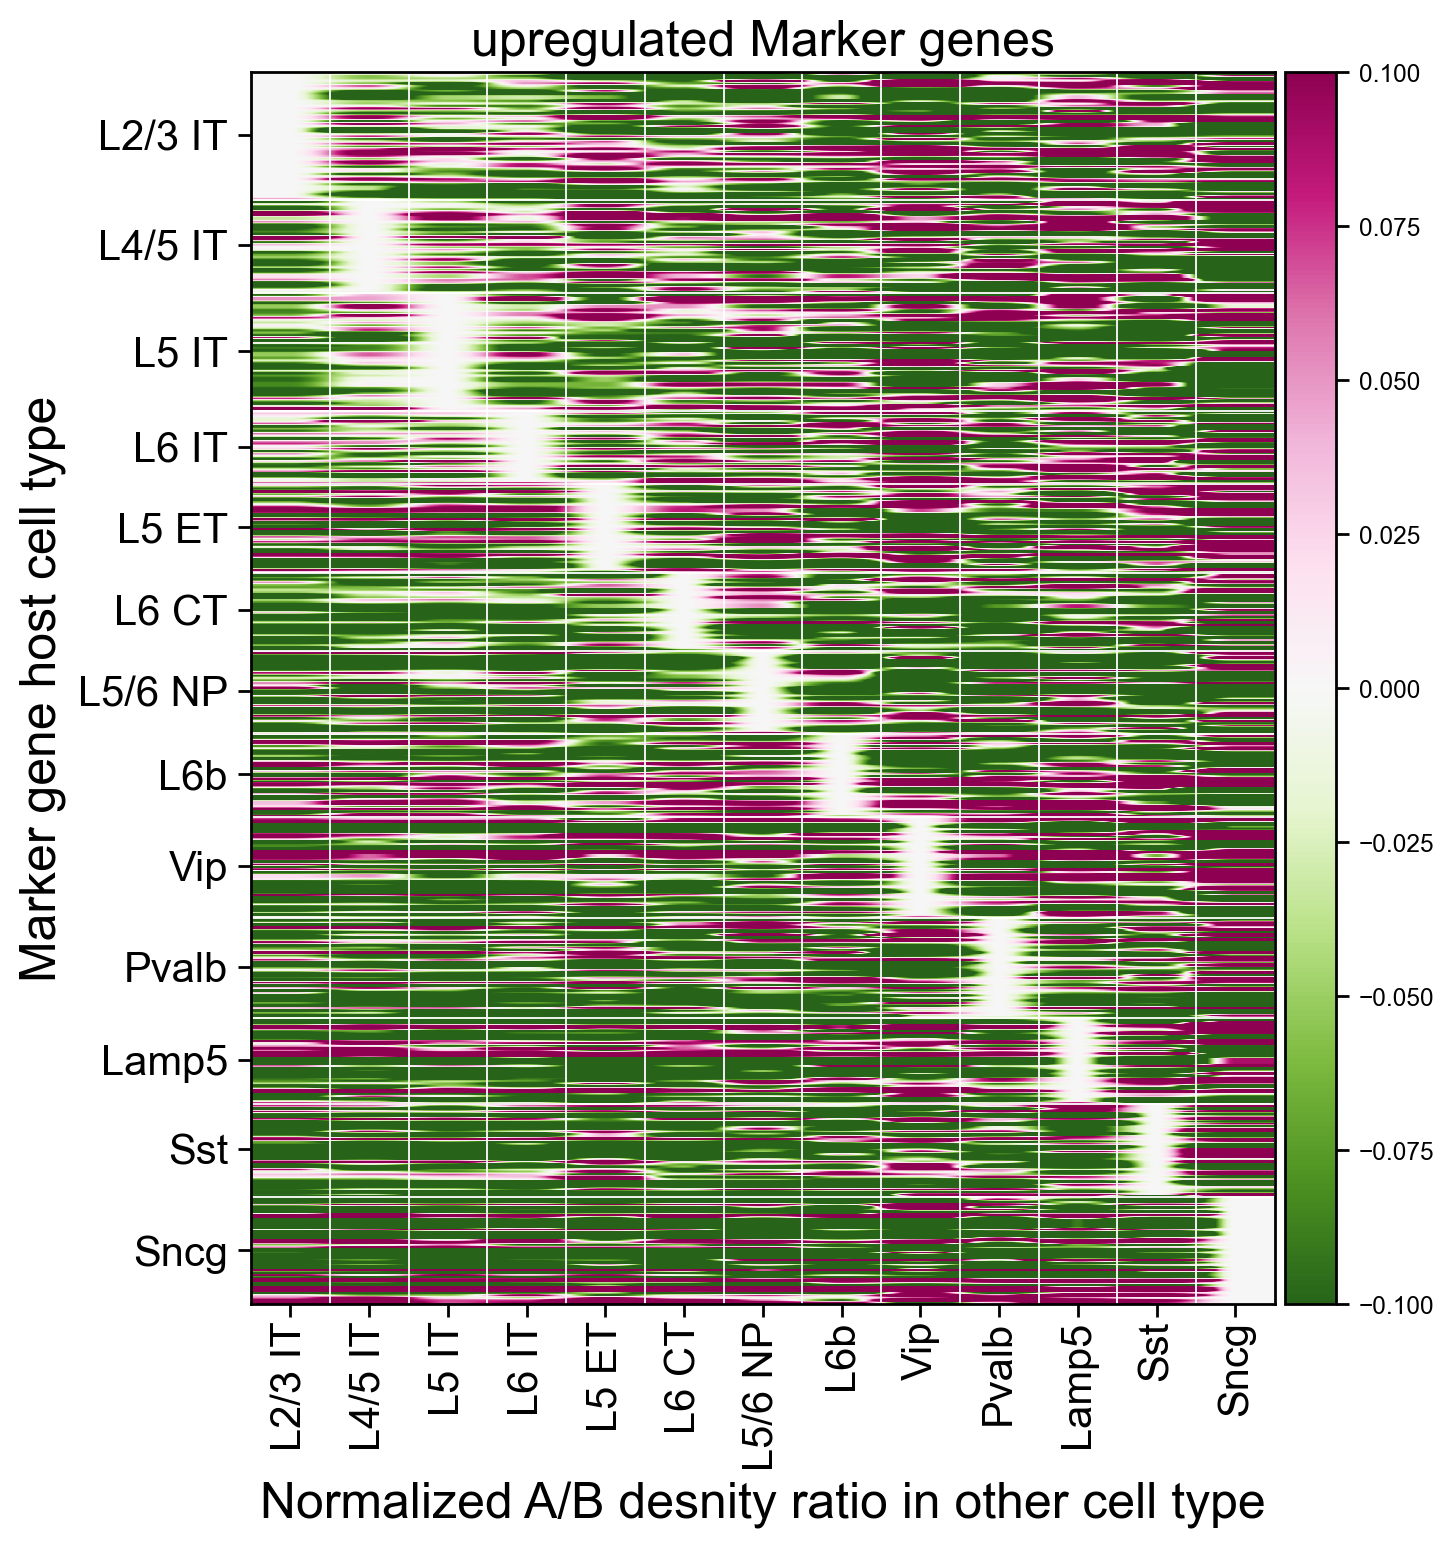

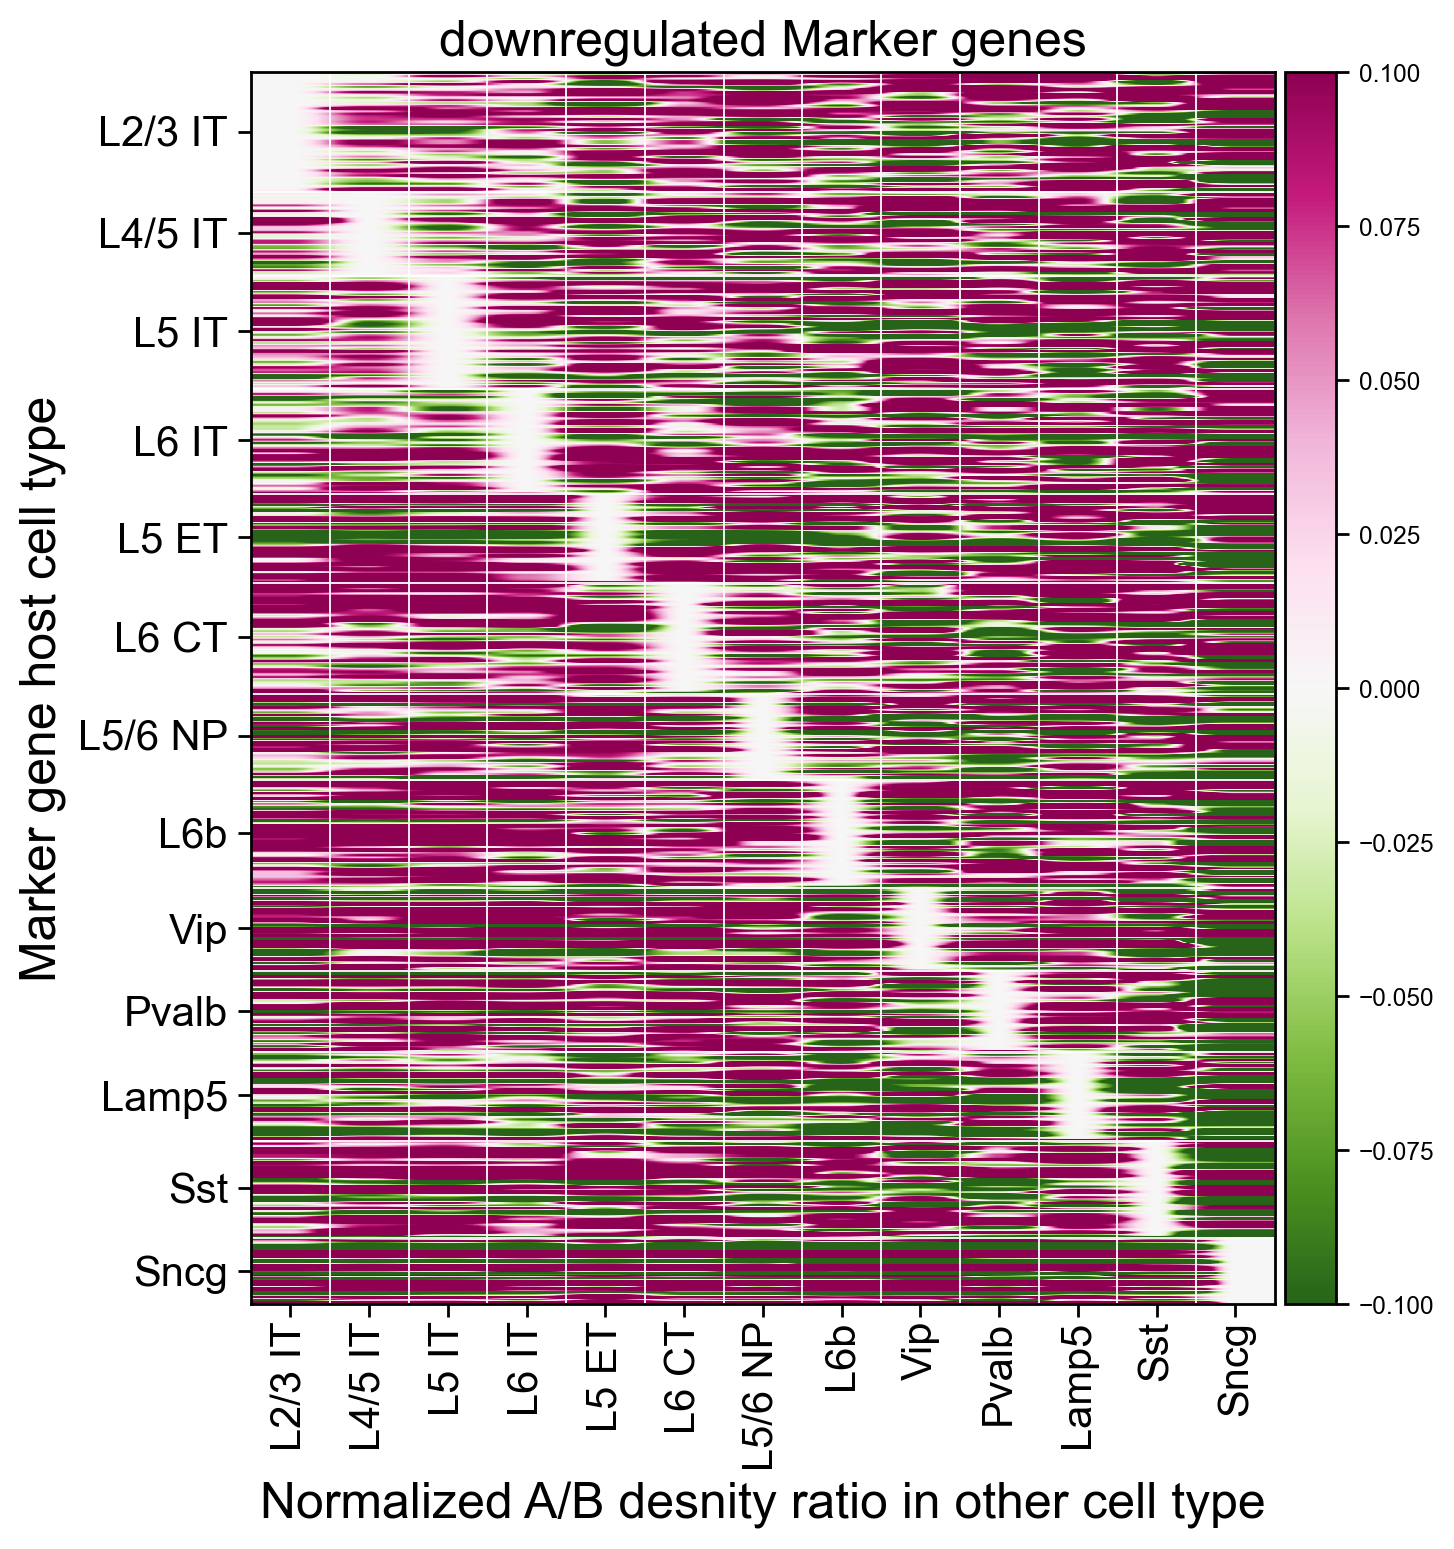

In [22]:
%matplotlib inline



for _dir in ['upregulated','downregulated']:
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 8) , dpi=200, sharex=True, sharey=True)
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    
    mat_df = sub_compiled_df[sorted_group_order]
    mat_plot = mat_df.to_numpy()

    _im = ax.imshow(mat_plot, vmin=0.8, vmax=1.2, cmap='PiYG_r')
    _im = ax.imshow(mat_plot, vmin=-0.1, vmax=0.1,  cmap='PiYG_r')
    #_im = ax.imshow(SE_ratio_mat, vmin=0.99, vmax=1.05, cmap='viridis')
    #vmin, vmax = 0.8, 1.25


    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns)))
    ax.set_xticklabels(labels = mat_df.columns,fontsize=15,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    group_nums = np.array(sub_compiled_df.groupby(['Marker_group'],sort=False).size().tolist())
    group_edges = np.cumsum(group_nums)
    yticks = (group_edges[1:] + group_edges[:-1])/2
    yticks = np.insert(yticks,0, int(group_nums[0]/2))
    yticks=[(_t-0.5) for _t in yticks]
    ax.set_yticks(ticks = yticks)
    ytick_labels  = [f'{_l}' for _l in group_plot]
    ax.set_yticklabels(labels = ytick_labels, fontsize=15,
               rotation=0)
    
    
    ax.tick_params('x', #labelsize=_font_size-1, 
                    #width=_ticklabel_width, length=_ticklabel_size,
                    labeltop=False,
                    pad=1, )

    # lines for separating
    ax.hlines(group_edges[:-1], -0.5, len(mat_df.columns)-0.5, color='white', linewidth=0.65)
    ax.vlines(np.arange(len(mat_df.columns))+0.5, -0.5, len(mat_df)-0.5, color='white', linewidth=0.65)

    #ax.xaxis.tick_top()
    ax.set_aspect('auto')

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(_im, cax=cax)
    
    ax.set_title(f'{_dir} Marker genes', fontsize=18)
    ax.set_xlabel('Normalized A/B desnity ratio in other cell type', fontsize=18)
    ax.set_ylabel('Marker gene host cell type', fontsize=18)

#plt.show()

## Reduce loci for each marker group to its median

In [24]:
len(mat_plot)

457

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_39764\3685482457.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_39764\3685482457.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]


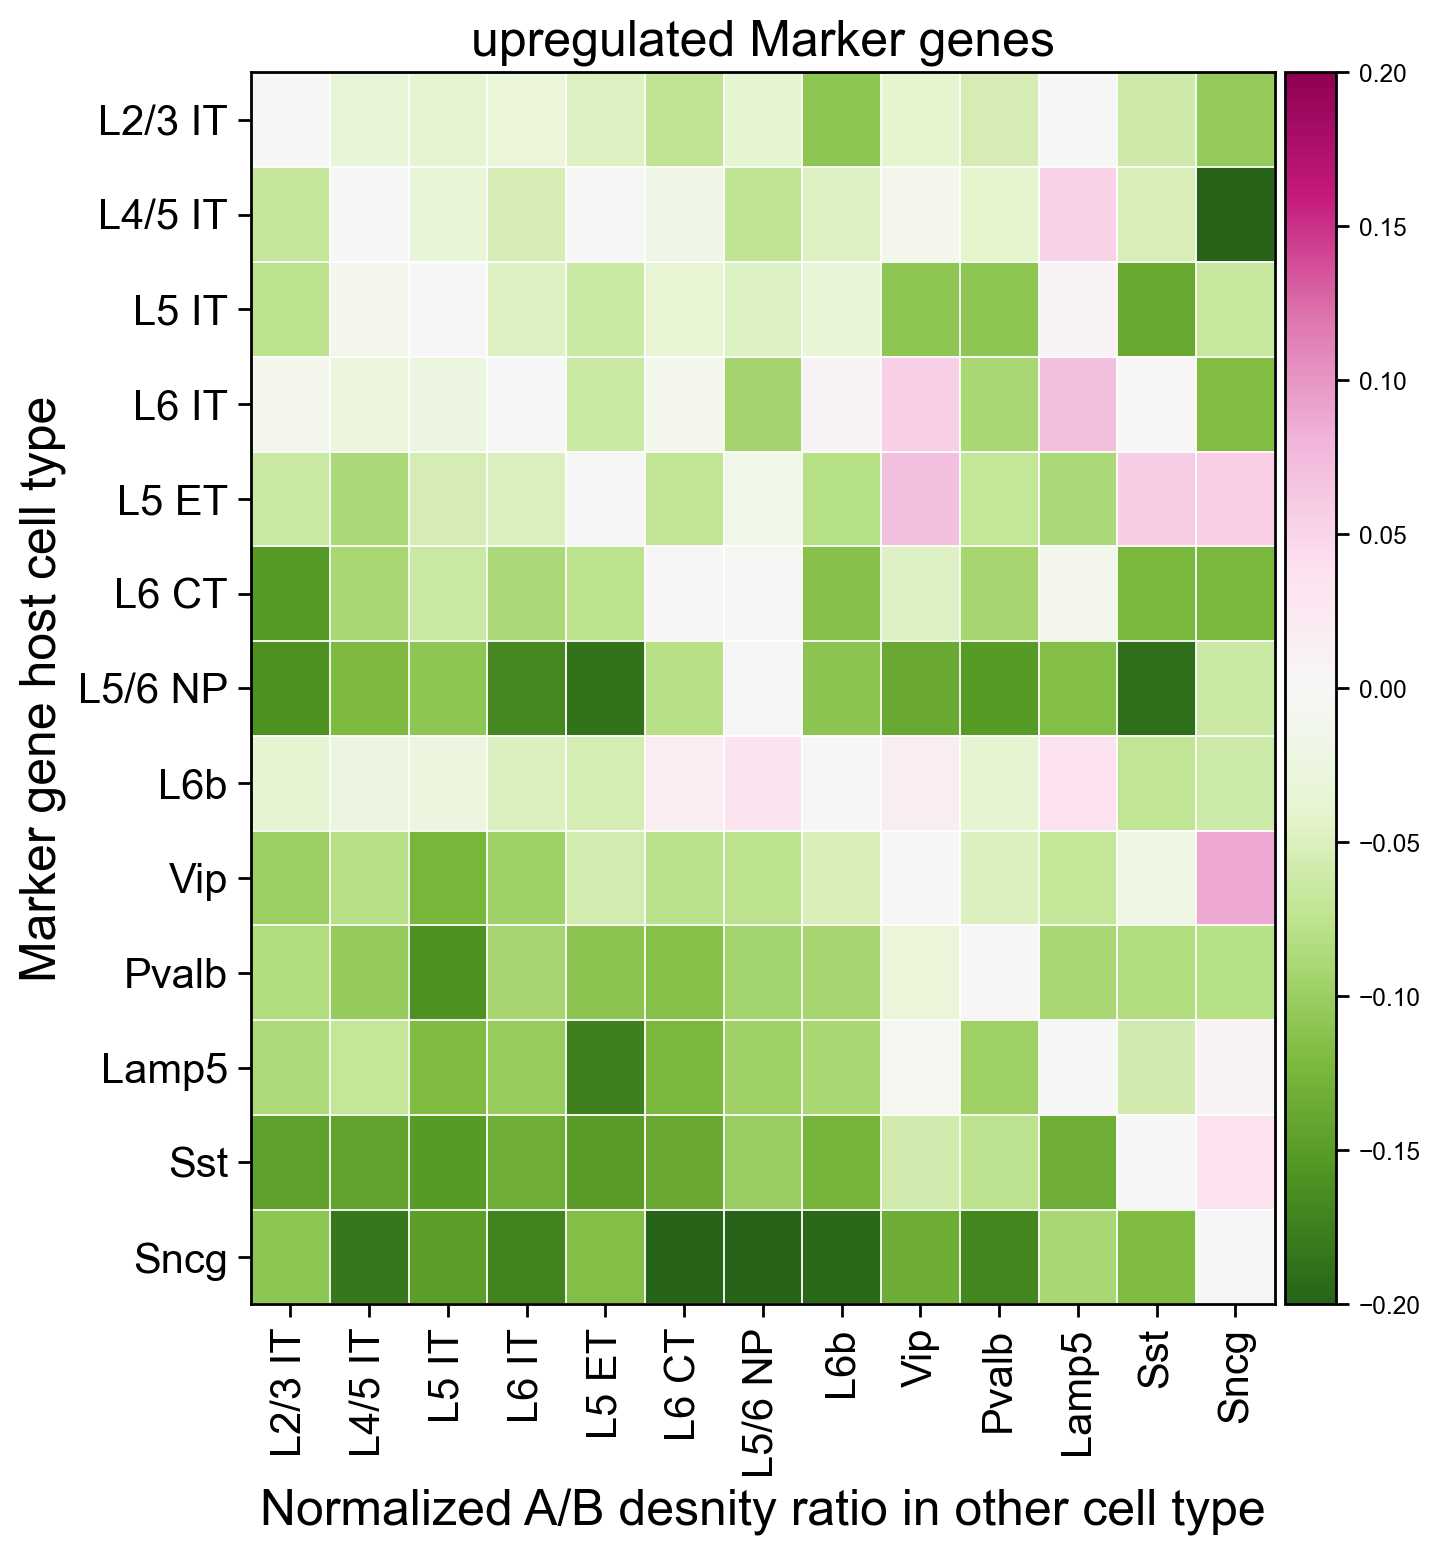

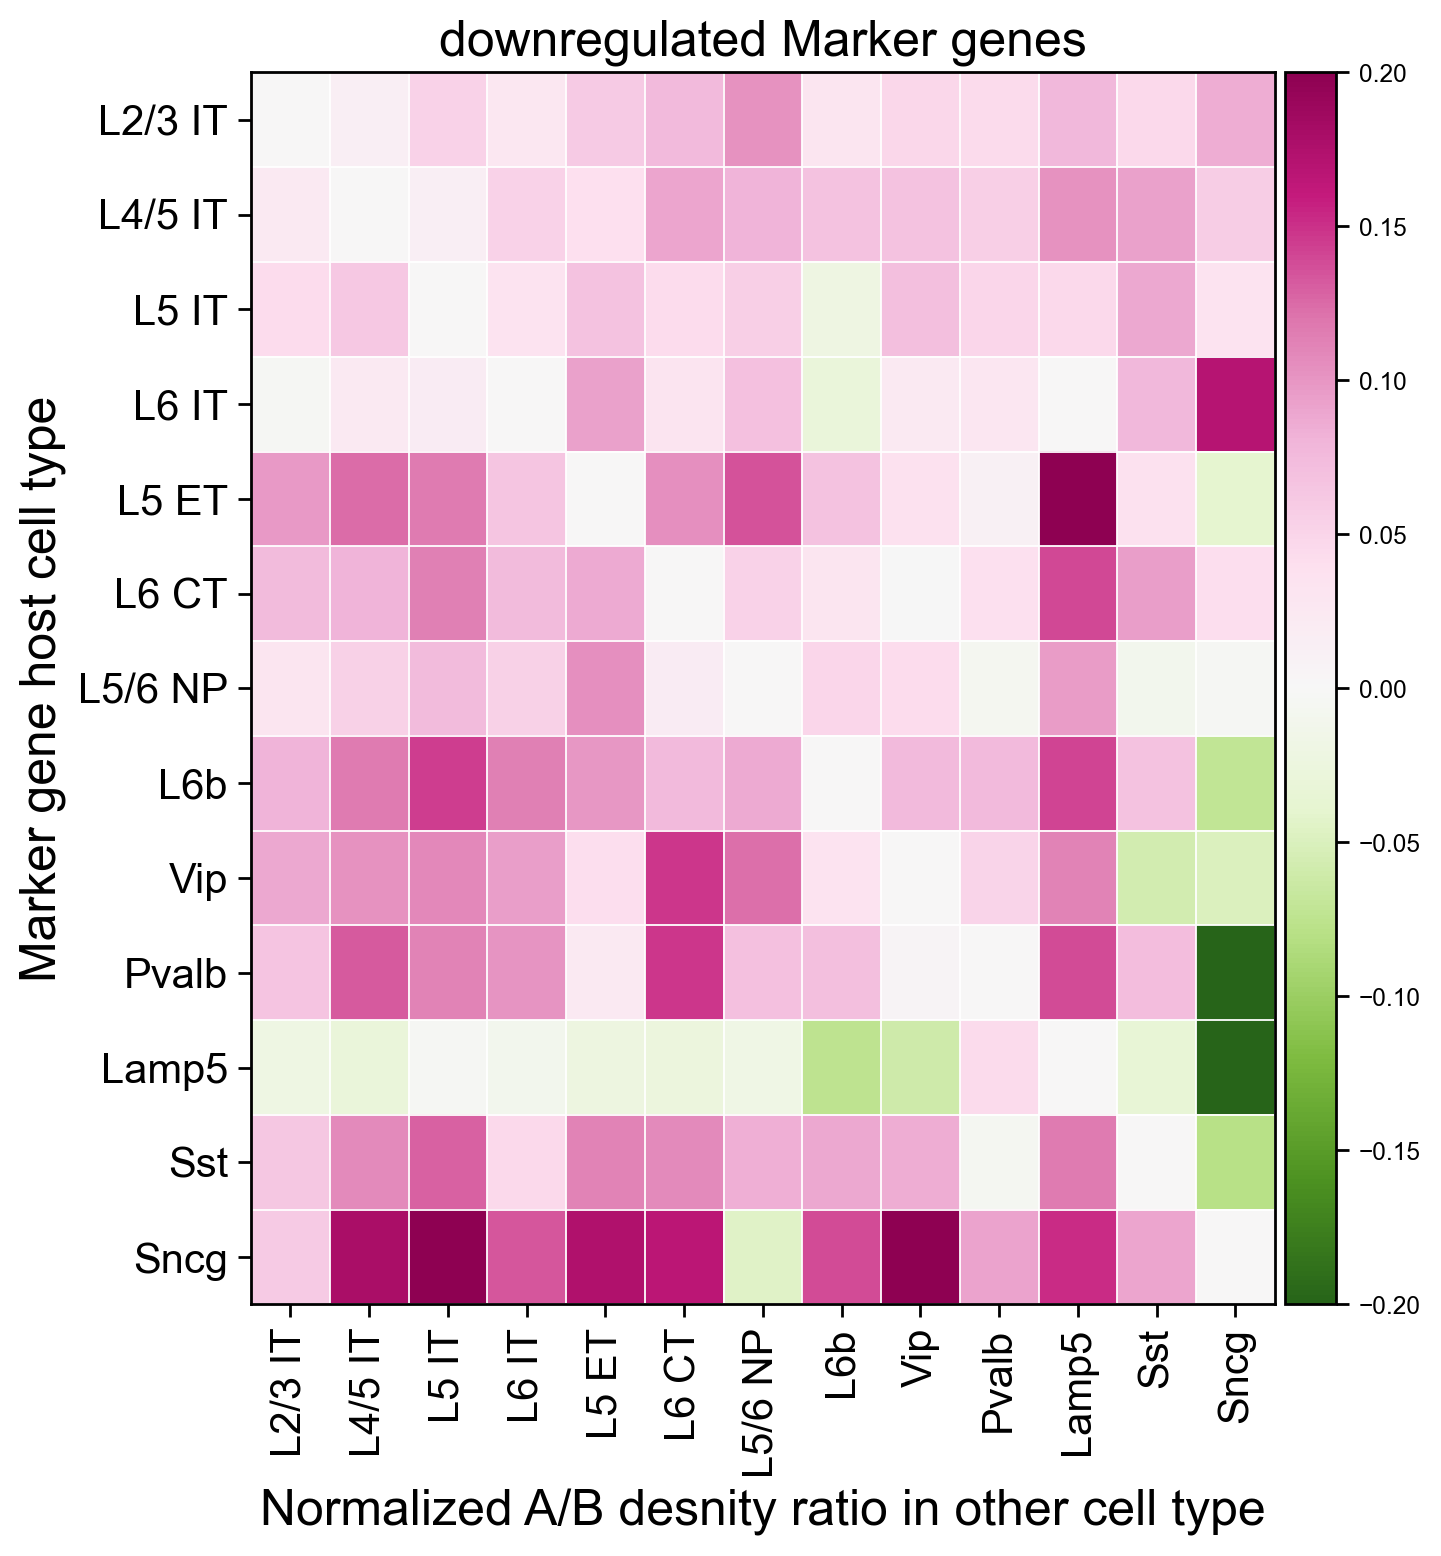

In [24]:
%matplotlib inline




for _dir in ['upregulated','downregulated']:
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 8) , dpi=200, sharex=True, sharey=True)
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    
    mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
    mat_plot = mat_df.to_numpy()

    _im = ax.imshow(mat_plot, vmin=-0.2, vmax=0.2, cmap='PiYG_r')
    #_im = ax.imshow(SE_ratio_mat, vmin=0.99, vmax=1.05, cmap='viridis')

    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns)))
    ax.set_xticklabels(labels = mat_df.columns,fontsize=15,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    ax.set_yticks(ticks = np.arange(len(group_plot)))
    ytick_labels  = group_plot
    ax.set_yticklabels(labels = ytick_labels,fontsize=15,
               rotation=0)

    # lines for separating
    ax.hlines(np.arange(len(mat_df.columns))+0.5, -0.5, len(mat_df.columns)-0.5, color='white', linewidth=0.65)
    ax.vlines(np.arange(len(mat_df.columns))+0.5, -0.5, len(mat_df)-0.5, color='white', linewidth=0.65)

    #ax.xaxis.tick_top()
    ax.set_aspect('auto')

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(_im, cax=cax)
    
    ax.set_title(f'{_dir} Marker genes', fontsize=18)
    ax.set_xlabel('Normalized A/B desnity ratio in other cell type', fontsize=18)
    ax.set_ylabel('Marker gene host cell type', fontsize=18)
    ax.set_ylabel('Marker gene host cell type', fontsize=18)

